In [ ]:
# The MLP teacher model to predict the california housing dataset 

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler, QuantileTransformer 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

tf.compat.v1.enable_eager_execution()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import DistillerTree

In [4]:
# Load the saved dataset
wind_data_train = pd.read_csv('Data/wind_train_data.txt')
wind_data_test = pd.read_csv('Data/wind_test_data.txt')

In [5]:
# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set

print(wind_data_train.shape)

print(wind_data_test.shape)

(33864, 31)
(14514, 31)


In [6]:
# Perform the stratified 10 fold cross validation
number_of_folds = 10

kfolds = KFold(n_splits=number_of_folds)

x_train = wind_data_train.loc[:, [
    'A_Air_temp', 'A_Precip', 'A_Syno_wind_speed',
       'A_Syno_wind_dir', 'A_Avg_wind_speed', 'A_Avg_wind_dir', 'B_Air_temp',
       'B_Precip', 'C_Air_temp', 'C_Precip', 'C_Syno_wind_speed',
       'C_Syno_wind_dir', 'D_Air_temp', 'D_Precip', 'D_Syno_wind_speed',
       'D_Syno_wind_dir', 'D_Avg_wind_speed', 'D_Avg_wind_dir', 'E_Air_temp',
       'E_Precip', 'E_Syno_wind_speed', 'E_Syno_wind_dir', 'E_Avg_wind_speed',
       'E_Avg_wind_dir'
]].to_numpy()

y_train = wind_data_train.loc[:, [
    'Test_Avg_wind_speed',
      # 'Test_Avg_wind_dir'
]].to_numpy()

x_test = wind_data_test.loc[:, [
    'A_Air_temp', 'A_Precip', 'A_Syno_wind_speed',
       'A_Syno_wind_dir', 'A_Avg_wind_speed', 'A_Avg_wind_dir', 'B_Air_temp',
       'B_Precip', 'C_Air_temp', 'C_Precip', 'C_Syno_wind_speed',
       'C_Syno_wind_dir', 'D_Air_temp', 'D_Precip', 'D_Syno_wind_speed',
       'D_Syno_wind_dir', 'D_Avg_wind_speed', 'D_Avg_wind_dir', 'E_Air_temp',
       'E_Precip', 'E_Syno_wind_speed', 'E_Syno_wind_dir', 'E_Avg_wind_speed',
       'E_Avg_wind_dir'
]].to_numpy()

y_test = wind_data_test.loc[:, [
    'Test_Avg_wind_speed',
      # 'Test_Avg_wind_dir'
]].to_numpy()

In [7]:
# Build the MLP model
def buildStudentModel():
    model = models.Sequential()
    
    model.add(layers.Dense(256, activation='relu'))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [10]:
# Use RBF model as teacher  
reg =  RandomForestRegressor(max_depth = 10).fit(x_train, y_train)

teacher_model = DistillerTree.ModelWrapper(reg)

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [11]:
# Haperparameter used in the experiment
number_of_epochs = 30

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(kfolds.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = DistillerTree.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse'],
        student_loss_fn=tf.keras.losses.MeanSquaredError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10,
        run_eagerly=True
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['mse'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/30
953/953 [==============================] - 14s 15ms/step - mse: 16.9856 - student_loss: 16.9645 - distillation_loss: 1346.6420 - val_mse: 5.7353 - val_student_loss: 3.4492
Epoch 2/30
953/953 [==============================] - 14s 15ms/step - mse: 4.9929 - student_loss: 4.9900 - distillation_loss: 160.5341 - val_mse: 4.7305 - val_student_loss: 2.8229
Epoch 3/30
953/953 [==============================] - 14s 14ms/step - mse: 4.9436 - student_loss: 4.9570 - distillation_loss: 158.5499 - val_mse: 4.9259 - val_student_loss: 2.4688
Epoch 4/30
953/953 [==============================] - 12s 13ms/step - mse: 4.8747 - student_loss: 4.8725 - distillation_loss: 151.4440 - val_mse: 5.4187 - val_student_loss: 2.4383
Epoch 5/30
953/953 [==============================] - 13s 14ms/step - mse: 4.7625 - student_loss: 4.7614 - distillation_loss: 139.6532 - val_mse: 6.7137 - val_student_loss: 5.5143
Epoch 6/30
953/953 [==============================] - 13s 13ms/step - mse: 4.7424 - studen

Epoch 22/30
953/953 [==============================] - 1s 1ms/step - loss: 4.2678 - mse: 4.2678 - val_loss: 4.4598 - val_mse: 4.4598
Epoch 23/30
953/953 [==============================] - 1s 2ms/step - loss: 4.2868 - mse: 4.2868 - val_loss: 4.5498 - val_mse: 4.5498
Epoch 24/30
953/953 [==============================] - 2s 2ms/step - loss: 4.2833 - mse: 4.2833 - val_loss: 5.7006 - val_mse: 5.7006
Epoch 25/30
953/953 [==============================] - 2s 2ms/step - loss: 4.2552 - mse: 4.2552 - val_loss: 4.4914 - val_mse: 4.4914
Epoch 26/30
953/953 [==============================] - 1s 2ms/step - loss: 4.2329 - mse: 4.2329 - val_loss: 5.0021 - val_mse: 5.0021
Epoch 27/30
953/953 [==============================] - 1s 2ms/step - loss: 4.2226 - mse: 4.2226 - val_loss: 4.3300 - val_mse: 4.3300
Epoch 28/30
953/953 [==============================] - 1s 1ms/step - loss: 4.1926 - mse: 4.1926 - val_loss: 4.4085 - val_mse: 4.4085
Epoch 29/30
953/953 [==============================] - 1s 1ms/step - 

Epoch 13/30
953/953 [==============================] - 1s 1ms/step - loss: 4.4787 - mse: 4.4787 - val_loss: 4.2772 - val_mse: 4.2772
Epoch 14/30
953/953 [==============================] - 1s 2ms/step - loss: 4.3953 - mse: 4.3953 - val_loss: 4.4002 - val_mse: 4.4002
Epoch 15/30
953/953 [==============================] - 1s 1ms/step - loss: 4.3711 - mse: 4.3711 - val_loss: 5.7205 - val_mse: 5.7205
Epoch 16/30
953/953 [==============================] - 1s 1ms/step - loss: 4.4109 - mse: 4.4109 - val_loss: 4.3480 - val_mse: 4.3480
Epoch 17/30
953/953 [==============================] - 1s 2ms/step - loss: 4.3436 - mse: 4.3436 - val_loss: 5.6333 - val_mse: 5.6333
Epoch 18/30
953/953 [==============================] - 1s 2ms/step - loss: 4.3523 - mse: 4.3523 - val_loss: 4.2473 - val_mse: 4.2473
Epoch 19/30
953/953 [==============================] - 1s 2ms/step - loss: 4.3519 - mse: 4.3519 - val_loss: 4.3276 - val_mse: 4.3276
Epoch 20/30
953/953 [==============================] - 2s 2ms/step - 

Epoch 4/30
953/953 [==============================] - 1s 1ms/step - loss: 5.2628 - mse: 5.2628 - val_loss: 5.2642 - val_mse: 5.2642
Epoch 5/30
953/953 [==============================] - 1s 1ms/step - loss: 5.2073 - mse: 5.2073 - val_loss: 5.7139 - val_mse: 5.7139
Epoch 6/30
953/953 [==============================] - 1s 1ms/step - loss: 4.8976 - mse: 4.8976 - val_loss: 4.7072 - val_mse: 4.7072
Epoch 7/30
953/953 [==============================] - 1s 1ms/step - loss: 4.8783 - mse: 4.8783 - val_loss: 6.5242 - val_mse: 6.5242
Epoch 8/30
953/953 [==============================] - 1s 1ms/step - loss: 4.8693 - mse: 4.8693 - val_loss: 5.8716 - val_mse: 5.8716
Epoch 9/30
953/953 [==============================] - 2s 2ms/step - loss: 4.7194 - mse: 4.7194 - val_loss: 4.8214 - val_mse: 4.8214
Epoch 10/30
953/953 [==============================] - 1s 1ms/step - loss: 4.6439 - mse: 4.6439 - val_loss: 5.3789 - val_mse: 5.3789
Epoch 11/30
953/953 [==============================] - 1s 1ms/step - loss: 

953/953 [==============================] - 13s 14ms/step - mse: 4.2858 - student_loss: 4.2847 - distillation_loss: 90.8862 - val_mse: 4.3233 - val_student_loss: 6.8329
Epoch 20/30
953/953 [==============================] - 14s 14ms/step - mse: 4.2699 - student_loss: 4.2711 - distillation_loss: 89.5658 - val_mse: 4.3631 - val_student_loss: 6.5770
Epoch 21/30
953/953 [==============================] - 13s 14ms/step - mse: 4.2367 - student_loss: 4.2349 - distillation_loss: 87.1723 - val_mse: 4.2102 - val_student_loss: 6.4190
Epoch 22/30
953/953 [==============================] - 13s 14ms/step - mse: 4.2314 - student_loss: 4.2311 - distillation_loss: 85.8416 - val_mse: 4.1802 - val_student_loss: 6.3662
Epoch 23/30
953/953 [==============================] - 13s 14ms/step - mse: 4.1945 - student_loss: 4.1932 - distillation_loss: 82.9335 - val_mse: 4.3253 - val_student_loss: 6.7301
Epoch 24/30
953/953 [==============================] - 13s 13ms/step - mse: 4.1990 - student_loss: 4.1962 - dist

953/953 [==============================] - 13s 14ms/step - mse: 4.9588 - student_loss: 4.9584 - distillation_loss: 154.3594 - val_mse: 4.3500 - val_student_loss: 3.2228
Epoch 6/30
953/953 [==============================] - 14s 14ms/step - mse: 4.8989 - student_loss: 4.9030 - distillation_loss: 149.3305 - val_mse: 4.3576 - val_student_loss: 3.6626
Epoch 7/30
953/953 [==============================] - 14s 15ms/step - mse: 4.8563 - student_loss: 4.8546 - distillation_loss: 144.9424 - val_mse: 5.2608 - val_student_loss: 4.3712
Epoch 8/30
953/953 [==============================] - 14s 14ms/step - mse: 4.7069 - student_loss: 4.7089 - distillation_loss: 128.1393 - val_mse: 4.3442 - val_student_loss: 3.1446
Epoch 9/30
953/953 [==============================] - 13s 13ms/step - mse: 4.6745 - student_loss: 4.6763 - distillation_loss: 127.9266 - val_mse: 4.1889 - val_student_loss: 3.0547
Epoch 10/30
953/953 [==============================] - 13s 13ms/step - mse: 4.6174 - student_loss: 4.6183 - dis

953/953 [==============================] - 1s 1ms/step - loss: 4.4856 - mse: 4.4856 - val_loss: 4.4671 - val_mse: 4.4671
Epoch 19/30
953/953 [==============================] - 1s 1ms/step - loss: 4.4464 - mse: 4.4464 - val_loss: 4.3202 - val_mse: 4.3202
Epoch 20/30
953/953 [==============================] - 1s 1ms/step - loss: 4.4424 - mse: 4.4424 - val_loss: 3.9482 - val_mse: 3.9482
Epoch 21/30
953/953 [==============================] - 1s 1ms/step - loss: 4.3275 - mse: 4.3275 - val_loss: 3.9861 - val_mse: 3.9861
Epoch 22/30
953/953 [==============================] - 1s 2ms/step - loss: 4.3892 - mse: 4.3892 - val_loss: 4.4597 - val_mse: 4.4597
Epoch 23/30
953/953 [==============================] - 1s 1ms/step - loss: 4.3438 - mse: 4.3438 - val_loss: 3.9283 - val_mse: 3.9283
Epoch 24/30
953/953 [==============================] - 1s 1ms/step - loss: 4.3006 - mse: 4.3006 - val_loss: 3.9257 - val_mse: 3.9257
Epoch 25/30
953/953 [==============================] - 1s 2ms/step - loss: 4.2935

953/953 [==============================] - 1s 1ms/step - loss: 4.9491 - mse: 4.9491 - val_loss: 5.4377 - val_mse: 5.4377
Epoch 10/30
953/953 [==============================] - 1s 1ms/step - loss: 4.8611 - mse: 4.8611 - val_loss: 4.5933 - val_mse: 4.5933
Epoch 11/30
953/953 [==============================] - 1s 1ms/step - loss: 4.7667 - mse: 4.7667 - val_loss: 6.5307 - val_mse: 6.5307
Epoch 12/30
953/953 [==============================] - 1s 1ms/step - loss: 4.6662 - mse: 4.6662 - val_loss: 5.1582 - val_mse: 5.1582
Epoch 13/30
953/953 [==============================] - 1s 1ms/step - loss: 4.6755 - mse: 4.6755 - val_loss: 5.1714 - val_mse: 5.1714
Epoch 14/30
953/953 [==============================] - 1s 1ms/step - loss: 4.5561 - mse: 4.5561 - val_loss: 4.5446 - val_mse: 4.5446
Epoch 15/30
953/953 [==============================] - 1s 1ms/step - loss: 4.4943 - mse: 4.4943 - val_loss: 4.8084 - val_mse: 4.8084
Epoch 16/30
953/953 [==============================] - 1s 1ms/step - loss: 4.4514

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:a] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Epoch 1/100
1059/1059 [==============================] - 3s 2ms/step - loss: 2.6384 - mse: 14.9561 - mae: 2.6384 - mape: 576477.1875
Epoch 2/100
1059/1059 [==============================] - 2s 2ms/step - loss: 2.0001 - mse: 6.6909 - mae: 2.0001 - mape: 242755.9688
Epoch 3/100
1059/1059 [==============================] - 2s 2ms/step - loss: 1.8743 - mse: 5.8704 - mae: 1.8743 - mape: 260653.8125
Epoch 4/100
1059/1059 [==============================] - 2s 2ms/step - loss: 1.8259 - mse: 5.6046 - mae: 1.8259 - mape: 434920.1562
Epoch 5/100
1059/1059 [==============================] - 2s 2ms/step - loss: 1.7970 - mse: 5.4326 - mae: 1.7970 - mape: 412147.1562
Epoch 6/100
1059/1059 [==============================] - 3s 2ms/step - loss: 1.7489 - mse: 5.1193 - mae: 1.7489 - mape: 452664.3438
Epoch 7/100
1059/1059 [==============================] - 2s 2ms/step - loss: 1.7176 - mse: 4.9770 - mae: 1.7176 - mape: 409021.3125
Epoch 8/100
1059/1059 [==============================] - 2s 2ms/step - loss

Validation mse with distillation 4.1156 +- 1.222
Validation mse without disstillation 4.4337 +- 0.5251


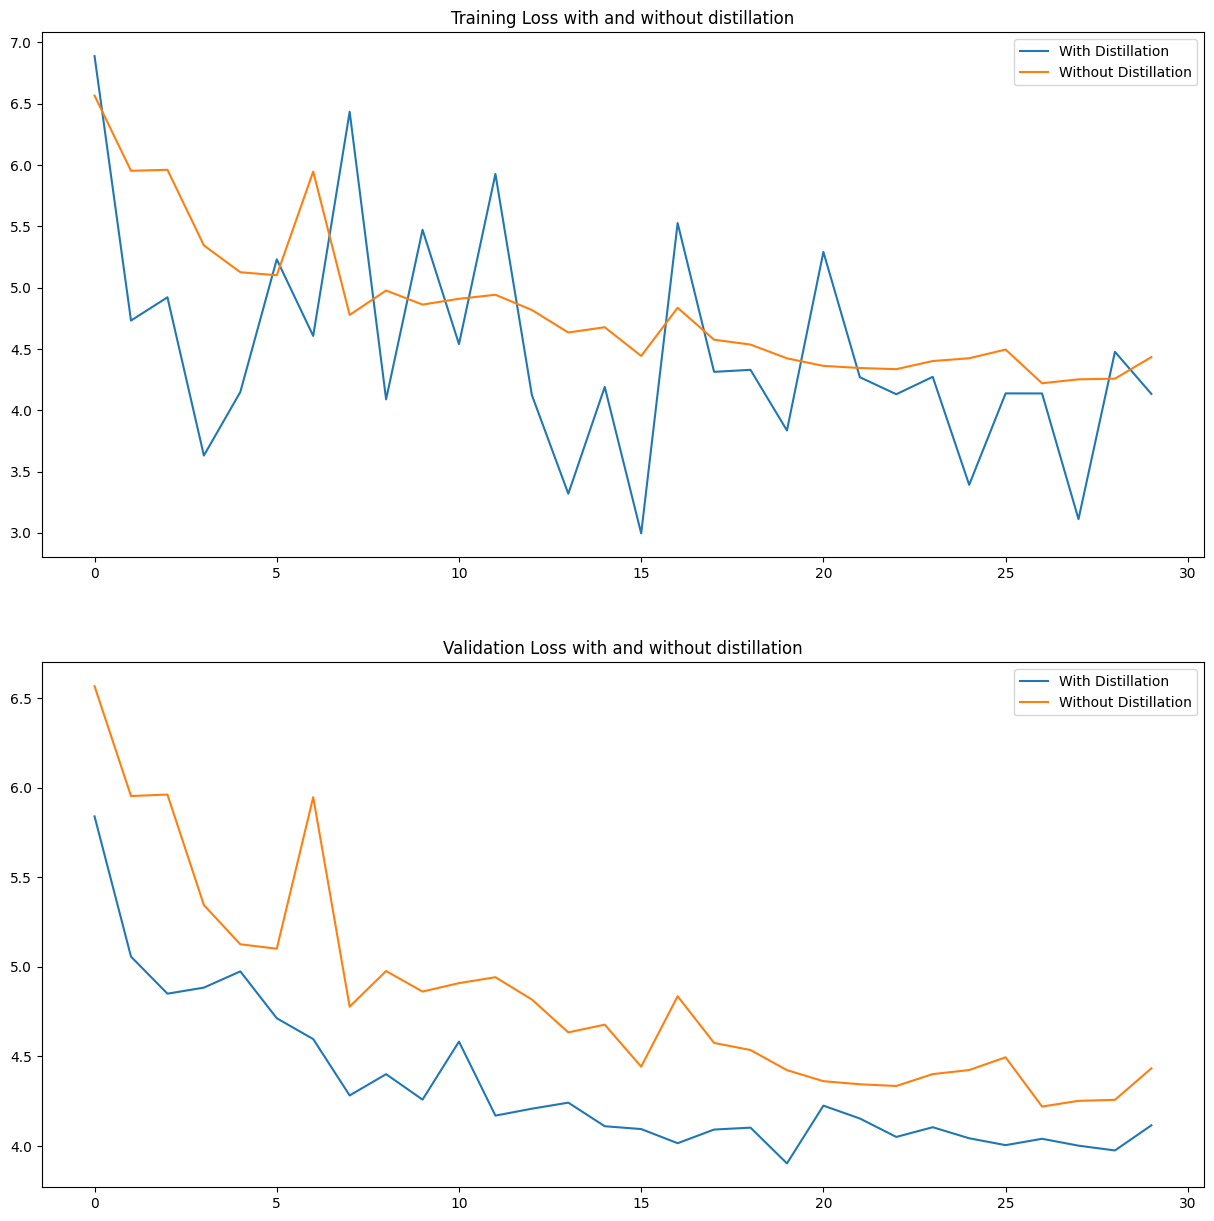

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [15]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = DistillerTree.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse'],
    student_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10,
    run_eagerly=True
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/30
1059/1059 [==============================] - 14s 13ms/step - mse: 9.6528 - student_loss: 9.6553 - distillation_loss: 621.1570
Epoch 2/30
1059/1059 [==============================] - 15s 14ms/step - mse: 5.6024 - student_loss: 5.6013 - distillation_loss: 220.6316
Epoch 3/30
1059/1059 [==============================] - 15s 15ms/step - mse: 5.1386 - student_loss: 5.1402 - distillation_loss: 174.5642
Epoch 4/30
1059/1059 [==============================] - 15s 14ms/step - mse: 5.1072 - student_loss: 5.1151 - distillation_loss: 167.4286
Epoch 5/30
1059/1059 [==============================] - 15s 14ms/step - mse: 4.8692 - student_loss: 4.8653 - distillation_loss: 143.3260
Epoch 6/30
1059/1059 [==============================] - 22s 21ms/step - mse: 4.7662 - student_loss: 4.7647 - distillation_loss: 134.4422
Epoch 7/30
1059/1059 [==============================] - 27s 26ms/step - mse: 4.6975 - student_loss: 4.7016 - distillation_loss: 131.1750
Epoch 8/30
1059/1059 [===================

In [16]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 4.177615642547607, 'student_loss': 4.665823459625244}
Test mse without disstillation {'loss': 1.637255311012268, 'mse': 4.5598955154418945, 'mae': 1.637255311012268, 'mape': 952408.625}
